In [1]:
from qiskit import *
from qiskit.converters import circuit_to_dag
from qiskit.quantum_info import Operator
from qiskit.circuit.library.standard_gates import CPhaseGate, PhaseGate
from qiskit.visualization import array_to_latex

import quimb as qu
import quimb.tensor as qtn

import numpy as np
import math
import re

# Full QFT MPO circuit implementation

In [2]:
# Num qubits
N = 4
# 10 qubits and tag the initial wavefunction tensors
circ = qtn.Circuit(N=N)
circ.apply_gate('H', 0, gate_round=0)

circ.apply_gate_raw(CPhaseGate(np.pi/2).to_matrix(), [0, 1], gate_round=0, tags='P(pi/2)')
circ.apply_gate_raw(PhaseGate(np.pi/4).to_matrix(), [2], gate_round=0, tags='P(pi/4)')
circ.apply_gate_raw(PhaseGate(np.pi/8).to_matrix(), [3], gate_round=0, tags='P(pi/8)')

circ.apply_gate('H', 1, gate_round=0)
circ.apply_gate_raw(CPhaseGate(np.pi/2).to_matrix(), [1, 2], gate_round=0)
circ.apply_gate_raw(CPhaseGate(np.pi/4).to_matrix(), [1, 3], gate_round=0)

circ.apply_gate('H', 2, gate_round=0)
circ.apply_gate_raw(CPhaseGate(np.pi/2).to_matrix(), [2, 3], gate_round=0)

circ.apply_gate('H', 3, gate_round=0)

circ_tensors = circ.psi.tensors

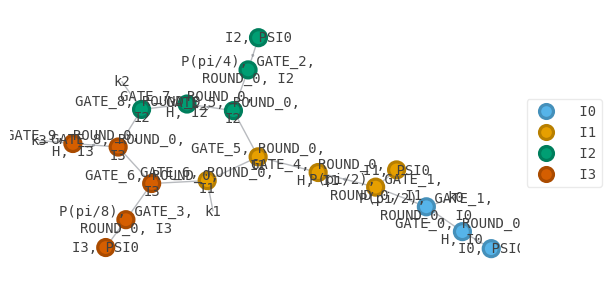

In [3]:
circ.psi.draw(color=[f'I{q}' for q in range(N)])

In [53]:
row = 1
col = 2
str_tuple = str((row, col))
print(str_tuple)

val1, val2 = (int(val) for val in str_tuple[1:-1].split(','))
print(val1)
print(val2)


(1, 2)
1
2


# Phase Tensor MPO

In [2]:
class Index:
    def __init__(self, *args, **kwargs):

        # When given a single argument, assume its a connected tag
        if len(args) == 1:
            self.nodes = sorted(self._parse_tag(args[0]))
        elif len(args) == 2:
            self.nodes = sorted([args[0], args[1]])

    def _parse_tag(self, tag: str):
        # Match between parenthesis
        return re.findall(r'\(.+?\)', tag)

    def contains(self, tag: str):
        return tag in self.nodes

    def getIntersections(self, other):
        return list(filter(lambda tag: tag in other.nodes, self.nodes))
    
    def replace(self, old_tag: str, new_tag):
        if self.contains(old_tag):
            self.nodes.remove(old_tag)
            self.nodes.append(new_tag)
            self.nodes = sorted(self.nodes)
            return True
        else:
            return False 

    def __str__(self) -> str:
        return f'{self.nodes[0]}<->{self.nodes[1]}'


tag1 = str((2, 4))
tag2 = str((1, 2))


idx = Index("(1, 2)<->(0, 1)")
print(idx.nodes)
print(idx)

['(0, 1)', '(1, 2)']
(0, 1)<->(1, 2)


In [167]:
class QFT:
    def __init__(self, N):
        self.tn = qtn.TensorNetwork([])
        self.N = N

    def getTag(self, row, col):
        '''
        Converts tuple of row, col to a string
        '''
        return str((row, col))

    def _getTagRowCol(self, tag):
        '''
        Converts a tag to a tuple of row, col
        '''
        return (int(val) for val in tag[1:-1].split(','))

    def _getIndexRowCol(self, index):
        '''
        Converts an index to a tuple of row, col
        '''
        return self._getTagRowCol(index)
    
    def _getClosestIndex(self, tensor, row, col):
        '''
        Gets the closest index of a tensor to a given row and col
        '''

        smallest_dist = math.inf
        closest_index = None

        # Get only indices that are not connected to other tensors
        unconnected_indices = filter(lambda i: '->' not in i, tensor.inds)
        for i in unconnected_indices:
            cur_row, cur_col = self._getIndexRowCol(i)
            cur_dist = math.sqrt((cur_row - row)**2 + (cur_col - col)**2)
            if cur_dist < smallest_dist:
                smallest_dist = cur_dist
                closest_index = i
        
        if closest_index is None:
            raise Exception('Could not find closest index')
        
        return closest_index


    def getTensorFromIndex(self, index):
        '''
        Gets a tensor from an index
        '''
        if index in self.tn.ind_map:
            matching_tensors = list(map(self.tn.tensor_map.get, self.tn.ind_map[index]))
            tensor = matching_tensors[0]
            return tensor
        else:
            return None
        
    def getTensorFromRowCol(self, row, col):
        '''
        Gets a tensor from a row and col
        '''
        tag = self.getTag(row, col)
        return self.getTensorFromTag(tag)
    
    def getTensorFromTag(self, tag):
        '''
        Gets a tensor from a tag
        '''
        if tag in self.tn.tag_map:
            # Complicated way of getting the tensor
            matching_tensors = list(map(self.tn.tensor_map.get, self.tn.tag_map[tag]))

            # return the first matching tensor
            tensor = matching_tensors[0]
            return tensor
        else:
            return None
        
    def getRowColTagFromTensor(self, tensor):
        '''
        Gets the row,col tag of a tensor
        '''
        for tag in tensor.tags:
            if tag[0] == '(':
                return tag


    def getIndices(self, tensor_row, tensor_col, bonds=[]):
        '''
        Gets corresponding indices for a tensor for each of its bonds.
        Also updates the tensor network with any matching bonds

        Parameters
        ----------
        tensor_row : int
            The row of the tensor within the quantum circuit.
            Row 0 is the top row.
        tensor_col : int
            The column of the tensor within the quantum circuit.
            Column 0 is the leftmost column.
        bonds : list of tuples
            A list of tuples representing the bonds indices the 
            tensor should connect to.

            ex: [(0, 1), (1, 0)] would connect the tensor to the
            tensor at row 0, col 1 and the tensor at row 1, col 0

        '''

        indices = []

        # Get the index based on row, col
        tensor_tag = self.getTag(tensor_row, tensor_col)

        # Loop through all our bonds and make idex connections
        for b in bonds:
            # Get our current bond row and col. Clamp it between the bounds of the tensor network
            bond_row, bond_col = b
            bond_tag = self.getTag(bond_row, bond_col)

            # Current bond index
            bond_index = Index(bond_tag, tensor_tag)
            indices.append(str(bond_index))

        return indices


    def add_hadamard(self, row, col):
        """
        Get the MPO for the Hadamard gate and place it at the given row and col

        Parameters
        ----------
        row : int
            The row of the tensor within the quantum circuit.
            Row 0 is the top row.
        col : int
            The column of the tensor within the quantum circuit.
            Column 0 is the leftmost column.
        """

        inds = self.getIndices(row, col, bonds=[(row, col-1), (row, col+1)])
        self.tn.add(qtn.Tensor(qu.hadamard(), inds=inds, tags=['H', self.getTag(row, col)]))


    def add_phase_MPO(self, start_row, end_row, col):
        '''
        Returns a tensor network MPO representing the controlled phase gates

        Parameters
        ----------
        start_row : int
            the starting row of the phase MPO
        '''

        # Define our control (copy tensor) in the form:
        # [ 
        #   [1, 0]  [0, 0] 
        #   [0, 0], [0, 1] 
        # ]
        # (MPO-QFT paper equation 53)
        copy_tensor = qtn.Tensor(
            data=np.array([ [[1, 0], [0,0]], [[0, 0], [0, 1]] ]), 
            inds = self.getIndices(start_row, col, bonds=[
                (start_row, col-1), 
                (start_row, col+1),
                (start_row+1, col)
            ]),
            tags = ['C', self.getTag(start_row, col)])

        self.tn.add(copy_tensor)
        
        # Apply each of our controlled phase gates in the form:
        # [
        #   [1, 0]  [0, 0]
        #   [0, 1], [0, 0],
        #   [0, 0]  [1, 0]
        #   [0, 0], [0, e^iπ)]
        # ]
        # (MPO-QFT paper equation 53)
        phase_count = 1
        for i in range(start_row+1, end_row-1):
            phase_denom = (2**(phase_count))
            phase = np.pi/phase_denom
            inds = self.getIndices(i, col, bonds=[
                (i, col-1), 
                (i, col+1),
                (i-1, col), 
                (i+1, col)
            ])

            self.tn.add(qtn.Tensor(
                data=CPhaseGate(phase).to_matrix().reshape(2,2,2,2),
                inds=inds,
                tags=['P', f'$\pi$/{phase_denom}', f'({i}, {col})']))

            phase_count += 1

        # Apply last phase gate in the form:
        # [ 
        #   [1, 0]
        #   [0, 1],
        #   [1, 0]
        #   [0, e^iπ)] 
        # ]
        # (MPO-QFT paper equation 53)
        last_phase = np.pi/(2**(phase_count))
        last_phase_gate_inds = self.getIndices(end_row-1, col, bonds=[
            (end_row-1, col-1), 
            (end_row-1, col+1), 
            (end_row-2, col)
        ])

        self.tn.add(qtn.Tensor(
            data=[qu.identity(2), qu.phase_gate(last_phase)],
            inds=last_phase_gate_inds,
            tags=['P', f'$\pi$/{2**(phase_count)}', self.getTag(end_row-1, col)]))
        
    def merge(self):
        '''
        Merges all unconnected indices of phase gates in our tensor network
        '''

        # Filter out all indices that are only connected to one tensor
        unconnected_indices_strs = filter(lambda i: len(self.tn.ind_map[i]) == 1, self.tn.ind_map.keys())

        # Convert the indices to Index objects
        unconnected_indices = list(map(lambda i: Index(i), unconnected_indices_strs))

        reindex_map = {}

        # Loop through each index and check if we have any intersecting indices
        for i in range(len(unconnected_indices)):
            cur_index = unconnected_indices[i]
            for j in range(i+1, len(unconnected_indices)):
                other_index = unconnected_indices[j]
                intersections = cur_index.getIntersections(other_index)
                if intersections is not None and len(intersections) > 0:
                    cur_tensor = self.getTensorFromIndex(str(cur_index))
                    other_tensor = self.getTensorFromIndex(str(other_index))

                    # Make sure we have two different tensors. Don't want to merge edges of the same tensor
                    if cur_tensor is not None and other_tensor is not None and cur_tensor != other_tensor:
                        # Get the indices we're merging on
                        cur_tensor_inds = self.getRowColTagFromTensor(cur_tensor)
                        other_tensor_inds = self.getRowColTagFromTensor(other_tensor)

                        # current remap index that we're going to merge into
                        cur_remap_index = Index(cur_tensor_inds, other_tensor_inds)

                        # Add the indices to our reindex map
                        reindex_map[str(cur_index)] = str(cur_remap_index)
                        reindex_map[str(other_index)] = str(cur_remap_index)


        # Finally, do an inplace remap of the indices
        self.tn.reindex(reindex_map, inplace=True)

    def create_circuit(self):
        '''
        Creates a tensor network circuit representing the quantum Fourier transform
        '''
        row = 0
        col = 0
        while row < self.N-1 and col < 2*self.N-1:
            self.add_hadamard(row, col)
            self.add_phase_MPO(row, self.N, col+1)

            row += 1
            col += 2

        # Important: merge all unconnected phase gates after we've built the circuit
        self.merge()
    
    def zip_up(self):
        '''
        Performs the zip-up algorithm on the phase gates in our tensor network
        '''
        phase0_tag = self.getTag(self.N-1, 1)
        phase1_tag = self.getTag(self.N-1, 3)

        self.tn.contract_between(phase0_tag, phase1_tag)
        
        
        
        li0 = str(Index(phase0_tag, self.getTag(self.N-2, 1)))
        li1 = str(Index(phase1_tag, self.getTag(self.N-2, 3)))
        self.tn.replace_with_svd([phase0_tag], left_inds=[li0, li1], eps=0.01, max_bond=2, inplace=True, ltags=['U'], rtags=['V'], keep_tags=False)
        # self.tn.drop_tags([phase0_tag, phase1_tag])
        
        # for row in range(self.N-1, 0, -1):
        #     for col in range(1, 2*self.N-1, 2):
        #         # Do zip up
        

    def draw(self):
        fix_dict = {}

        # Layout the tensor network in a grid
        for i in range(self.N*self.N):
            for j in range(self.N*self.N):
                fix_dict[f'({i}, {j})'] = (j, -i)

        self.tn.draw(color=['P','H', 'C'], figsize=(16, 16), show_inds='all', show_tags=True, initial_layout='shell', fix=fix_dict, font_size=10)

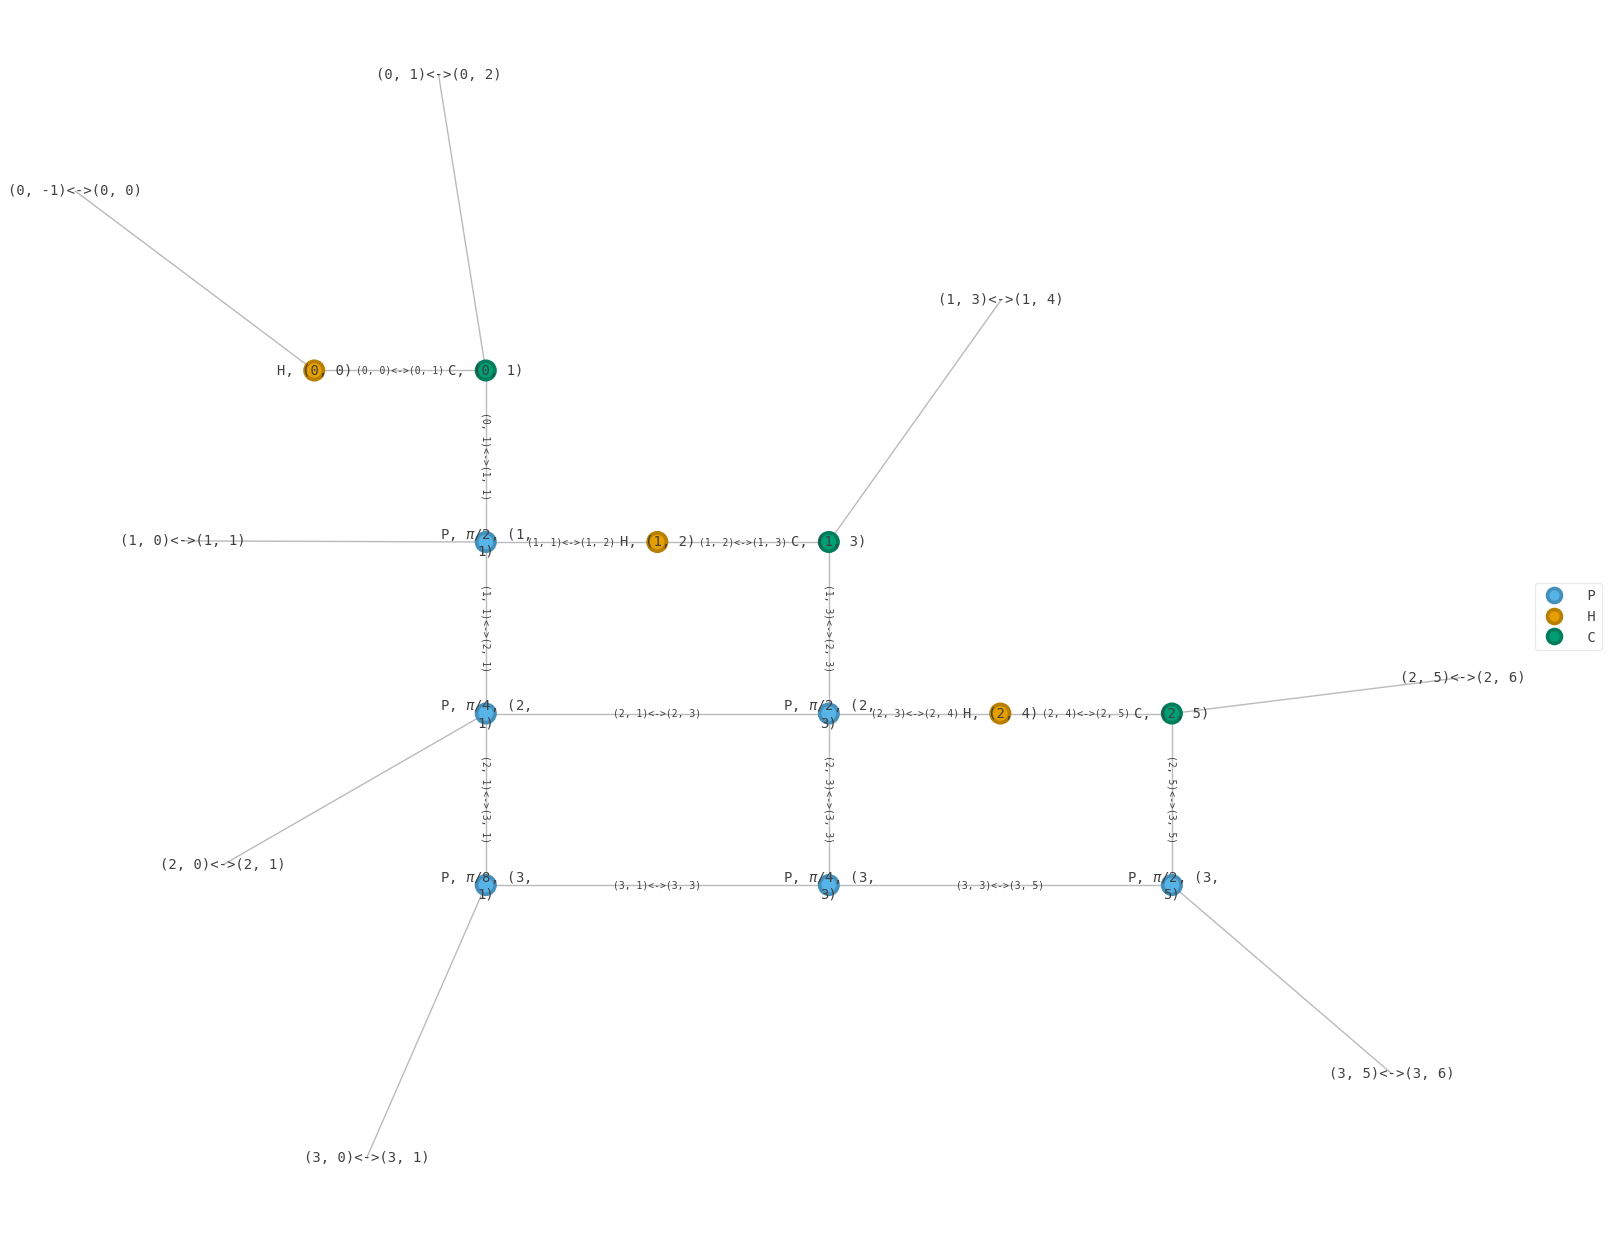

In [171]:
QFT_MPO = QFT(4)
QFT_MPO.create_circuit()
QFT_MPO.draw()

In [2]:
def getQ(row, col):
    return f'q{row},{col}'

def getC(row, col):
    return f'c{row},{col}'


In [3]:
def get_haddard_MPO(N, row, col):
    """
    Get the MPO for the Hadamard gate and place it at the given row and col
    """
    tensors = []
    for i in range(N):
        inds=[getQ(i, col), getQ(i, col+1)]

        tag = '(' + i + ',' + col + ')'
        tag = '({}, {})'.format(i, col)
        tag = f'{i}, {col}'
        if i == row:
            tensors.append(qtn.Tensor(qu.hadamard(), inds=inds, tags=['H', f'({i}, {col})']))
        else:
            tensors.append(qtn.Tensor(np.eye(2), inds=inds, tags=['I', f'({i}, {col})']))

    return tensors

In [4]:
def get_phase_MPO(start_row, end_row, col):
    '''
    Returns a tensor network MPO representing the controlled phase gates
    '''

    tensors = []

    for i in range(0, start_row):
        tensors.append(qtn.Tensor(qu.identity(2), inds=[getQ(i, col), getQ(i, col+1)], tags=['I', f'({i}, {col})']))

    # Define our control (copy tensor) in the form:
    # [ 
    #   [1, 0]  [0, 0] 
    #   [0, 0], [0, 1] 
    # ]
    # (MPO-QFT paper equation 53)
    copy_tensor = qtn.Tensor(
        data=np.array([ [[1, 0], [0,0]], [[0, 0], [0, 1]] ]), 
        inds=[getQ(start_row, col), getQ(start_row, col+1), getC(start_row, col)], 
        tags=['C', f'({start_row}, {col})'])

    tensors.append(copy_tensor)
    
    # Apply each of our controlled phase gates in the form:
    # [
    #   [1, 0]  [0, 0]
    #   [0, 1], [0, 0],
    #   [0, 0]  [1, 0]
    #   [0, 0], [0, e^iπ)]
    # ]
    # (MPO-QFT paper equation 53)
    phase_count = 1
    for i in range(start_row+1, end_row-1):
        phase_denom = (2**(phase_count))
        phase = np.pi/phase_denom
        inds=[getQ(i, col), getQ(i, col+1),getC(i-1, col), getC(i, col)]

        tensors.append(qtn.Tensor(
            data=CPhaseGate(phase).to_matrix().reshape(2,2,2,2),
            inds=inds,
            tags=['P', f'$\pi$/{phase_denom}', f'({i}, {col})']))

        phase_count += 1

    # Apply last phase gate in the form:
    # [ 
    #   [1, 0]
    #   [0, 1],
    #   [1, 0]
    #   [0, e^iπ)] 
    # ]
    # (MPO-QFT paper equation 53)
    last_phase = np.pi/(2**(phase_count))
    tensors.append(qtn.Tensor(
        data=[qu.identity(2), qu.phase_gate(last_phase)],
        inds=[getQ(end_row-1, col), getQ(end_row-1, col+1), getC(end_row-2, col)],
        tags=['P', f'$\pi$/{2**(phase_count)}', f'({end_row-1}, {col})']))
    
    return tensors

In [5]:
def merge_neighboring_indices(tn, end_row, end_col):
    """
    Merge neighboring indices of phase tensors 
    """
    start_row = 2
    start_col = 2
    for col in range(start_col, end_col, 2):
        for row in range(start_row, end_row):
            tn.reindex({getQ(row, col): getQ(row, col+1)}, inplace=True)


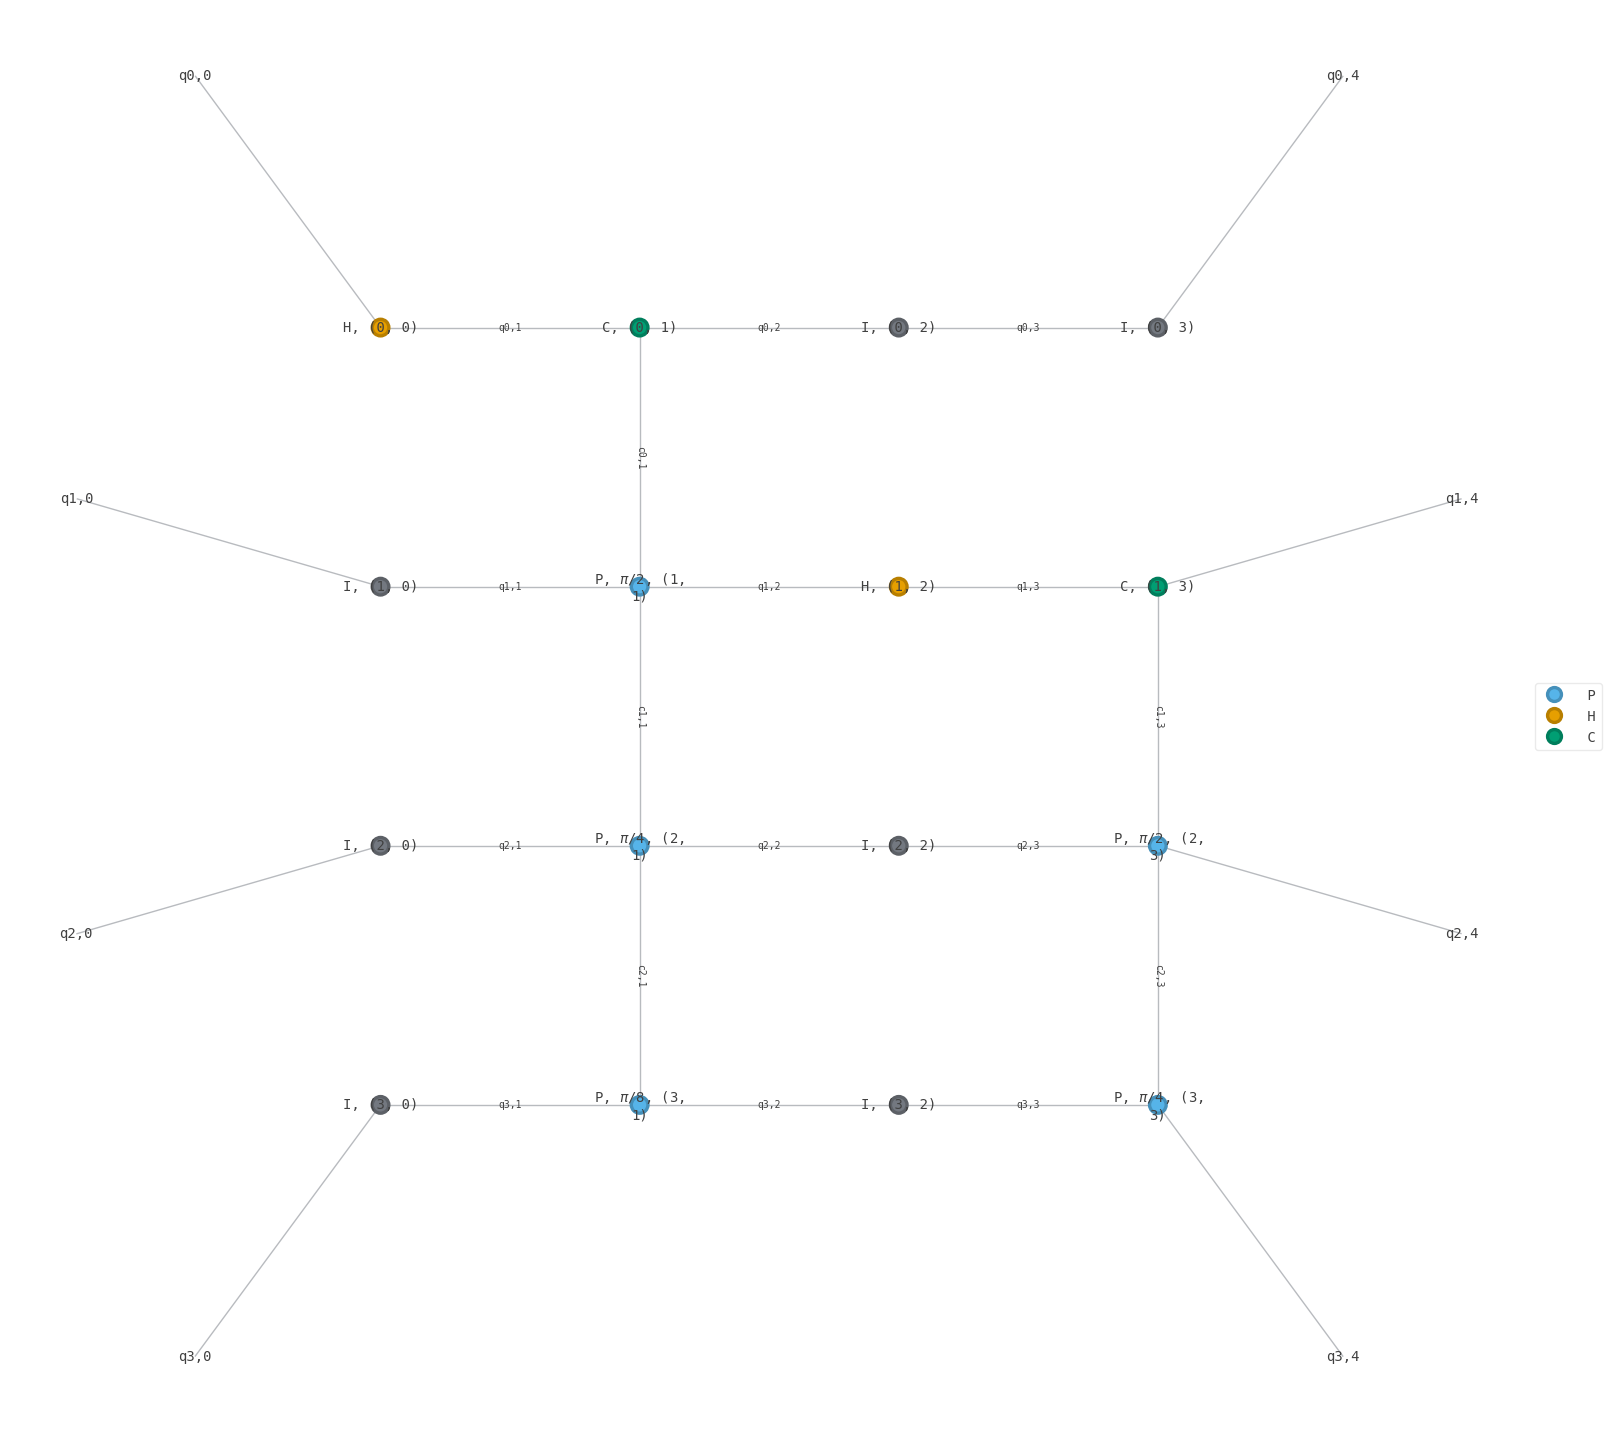

In [16]:
tensors = []

tensors.extend(get_haddard_MPO(N, 0, 0))
tensors.extend(get_phase_MPO(0, N, 1))
tensors.extend(get_haddard_MPO(N, 1, 2))
tensors.extend(get_phase_MPO(1, N, 3))
tensors.extend(get_haddard_MPO(N, 2, 4))
tensors.extend(get_phase_MPO(2, N, 5))
tensors.extend(get_haddard_MPO(N, 3, 6))
# print(tensors)
tn = qtn.TensorNetwork(tensors)
fix_dict = {}

# Layout the tensor network in a grid
for i in range(N*N):
    for j in range(N*N):
        fix_dict[f'({i}, {j})'] = (j, -i)

tn.draw(color=['P','H', 'C'], figsize=(16, 16), show_inds='all', show_tags=True, initial_layout='shell', fix=fix_dict, font_size=10)

In [239]:
phase_mpo1 = get_phase_MPO(N, 1, N, 2)
phase_mpo1.draw(color=['P'], figsize=(10, 10), show_inds='all', show_tags=True)

TypeError: get_phase_MPO() takes 3 positional arguments but 4 were given

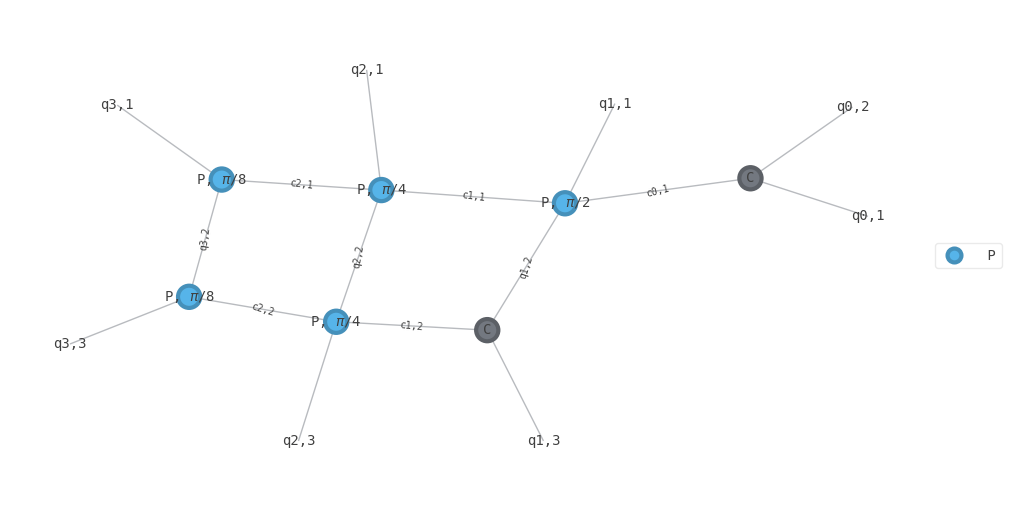

In [182]:
phase_mpo0.add_tensor_network(phase_mpo1, virtual=True)
phase_mpo0.draw(color=['P'], figsize=(10, 10), show_inds='all', show_tags=True)

In [135]:
def zip_up(tn, N):
    for i in range(N-1, 0):

SyntaxError: incomplete input (2684517071.py, line 2)

In [146]:
sorted_circ_tensors = circ.psi.tensors

for i in range(0, len(sorted_circ_tensors), 1):
    print(f"{i}: {sorted_circ_tensors[i]}")


# Contract phase tensors
contracted_tensor = sorted_circ_tensors[10] @ sorted_circ_tensors[15]

print(contracted_tensor)

# Split the tensor with svd
svd_tn = qtn.tensor_core.tensor_split(contracted_tensor, left_inds='_fe41d3AAAAI')

print(svd_tn)



0: Tensor(shape=(2,), inds=('_fe41d3AAABM',), tags=oset(['I0', 'PSI0']), backend='numpy', dtype='complex128')
1: Tensor(shape=(2,), inds=('_fe41d3AAABO',), tags=oset(['I1', 'PSI0']), backend='numpy', dtype='complex128')
2: Tensor(shape=(2,), inds=('_fe41d3AAABP',), tags=oset(['I2', 'PSI0']), backend='numpy', dtype='complex128')
3: Tensor(shape=(2,), inds=('_fe41d3AAABQ',), tags=oset(['I3', 'PSI0']), backend='numpy', dtype='complex128')
4: Tensor(shape=(2, 2), inds=('_fe41d3AAABN', '_fe41d3AAABM'), tags=oset(['GATE_0', 'ROUND_0', 'H', 'I0']), backend='numpy', dtype='complex128')
5: Tensor(shape=(2, 2, 2), inds=('k0', '_fe41d3AAABN', 'b'), tags=oset(['P(pi/2)', 'GATE_1', 'ROUND_0', 'I0']), backend='numpy', dtype='complex128')
6: Tensor(shape=(2, 2, 2), inds=('b', 'k1', '_fe41d3AAABO'), tags=oset(['P(pi/2)', 'GATE_1', 'ROUND_0', 'I1']), backend='numpy', dtype='complex128')
7: Tensor(shape=(2, 2), inds=('k2', '_fe41d3AAABP'), tags=oset(['P(pi/4)', 'GATE_2', 'ROUND_0', 'I2']), backend='nump

IndexError: tuple index out of range

In [ ]:
circ.schrodinger_contract()